# Processing

The goal of this notebook is to convert the json data provided into color composite images that are the correct size for pretrained imagenet models (3x224x224). Since the images are just 75x75 that means there needs to be some interpolation or lot of padding.

In [3]:
from utils import *

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [36]:
from glob import glob

In [32]:
from sklearn.model_selection import train_test_split

In [4]:
path = os.curdir + '/data/processed/'
train_json = path + 'train.json'

In [5]:
train = pd.read_json(train_json)
train = train.replace(to_replace='na', value=np.nan)

In [6]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
#         r = ((band_1 - np.mean(band_1)) / (np.max(band_1) - np.min(band_1))) 
#         g = ((band_2 - np.mean(band_2)) / (np.max(band_2) - np.min(band_2))) 
#         b = ((band_3 - np.mean(band_3)) / (np.max(band_3) - np.min(band_3)))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [7]:
rgb_train = color_composite(train)

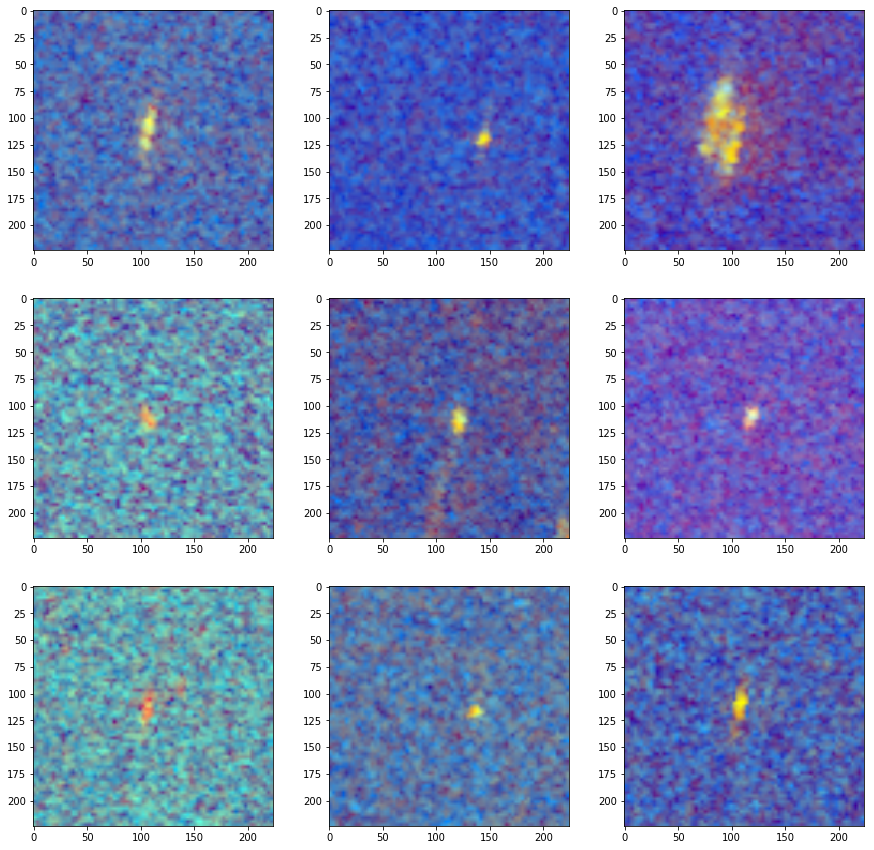

In [24]:
# Plot band_1
fig = plt.figure(1, figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = up_rgb[i+10]
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [23]:
save_array(path + 'rgb_train', up_rgb)

In [16]:
from cv2 import resize

In [19]:
up_rgb = [resize(image, dsize=(224,224)) for image in rgb_train]

In [31]:
# # making directories for training resnet (as it need files to be in right dir)

#os.makedirs(path+'composites')
#os.makedirs(path+'/composites/train')
#os.makedirs(path + '/composites/valid')
#os.makedirs(path + '/composites/test')
#os.makedirs(path+'/composites/train/ship')
#os.makedirs(path+'/composites/train/iceberg')
#os.makedirs(path+'/composites/valid/ship')
#os.makedirs(path+'/composites/valid/iceberg')

In [34]:
# split
train_y, valid_y = train_test_split(train.is_iceberg, test_size=0.20)

train_iceberg_index, train_ship_index, valid_iceberg_index, valid_ship_index  = train_y[train_y==1].index, train_y[train_y==0].index, valid_y[valid_y==1].index, valid_y[valid_y==0].index


#save train images
for idx in train_iceberg_index:
    img = rgb_train[idx]
    plt.imsave(path+'/composites/train/iceberg/' + str(idx) + '.png',  img)

for idx in train_ship_index:
    img = rgb_train[idx]
    plt.imsave(path+'/composites/train/ship/' + str(idx) + '.png',  img)    
    
#save valid images
for idx in valid_iceberg_index:
    img = rgb_train[idx]
    plt.imsave(path+'/composites/valid/iceberg/' + str(idx) + '.png',  img)

for idx in valid_ship_index:
    img = rgb_train[idx]
    plt.imsave(path+'/composites/valid/ship/' + str(idx) + '.png',  img)

#save test images
#for idx in range(len(test)):
#    img = rgb_test[idx]
#    plt.imsave(path+'/composites/test/' + str(idx) + '.png',  img)

In [35]:
#os.makedirs(path+'composites/sample/train')
#os.makedirs(path+'composites/sample/valid')
#os.makedirs(path+'composites/sample/train/iceberg')
#os.makedirs(path+'composites/sample/train/ship')
#os.makedirs(path+'composites/sample/valid/iceberg')
#os.makedirs(path+'composites/sample/valid/ship')

In [54]:
from shutil import copyfile
#Make a new glob and shuf array with different ordering to get files for the sample training directory
def sample(src, dst, size):
    """Move files to sample directory
    # Arguments
        src: location of directory files that you're sampling
        dst: location to move files, create dst if it doesn't exist
        size: size of sample (number of files moved)
    """
    g = glob(src + '*.png')
    shuf = np.random.permutation(g)
    
    #check for destination, create it if is doesn't exist
    if os.path.exists(dst)==False:
        os.mkdir(dst)
    
    for i in range(size): 
        copyfile(shuf[i], dst + shuf[i].split('/')[-1])

In [53]:
sample(path+'composites/train/iceberg/', path+'composites/sample/train/iceberg/', 100)
sample(path+'composites/train/ship/', path+'composites/sample/train/ship/', 100)
sample(path+'composites/valid/iceberg/', path+'composites/sample/valid/iceberg/', 25)
sample(path+'composites/train/ship/', path+'composites/sample/valid/ship/', 25)